In [1]:
using InteractiveIsing, GLMakie, FileIO, CairoMakie
using InteractiveIsing.Processes
import InteractiveIsing as II

## Utility functions for experiments
### Use ii. to check if the terms are correct
### Now the H is written like H_self + H_quartic
### Which is Jii*Si^2 + Qc*Jii*Si^4 wichi means Jii=a, Qc*Jii=b in a*Si^2 + b*Si^4

function newmakie(makietype, args...)
    f = makietype(args...)
    scr = GLMakie.Screen()
    display(scr, f)
    f
end

# Weight function variant 1
function weightfunc1(dr,c1,c2)
    prefac = 1
    d = delta(c1,c2)
    dx, dy, dz = d
    # Always positive coupling (ferromagnetic)
    return prefac / norm2(d)
end

function weightfunc2(dr, c1, c2)
    d = delta(c1, c2)
    dx, dy, dz = d  # 先解包
    physical_dr2 = sqrt((0.05*dx)^2 + (0.05*dy)^2 + (0.2*dz)^2) 
    # z 方向保持铁磁 (正耦合)
    # if dx == 0 && dy == 0
    #     prefac = 1
    # elseif dx == 0
    #     prefac = 1
    # else
    #     # xy 平面反铁磁 (负耦合)
    #     prefac = -1
    # end
    prefac = 1
    return prefac / physical_dr2
end

function weightfunc3(dr, c1, c2)
    d = delta(c1, c2)
    dx, dy, dz = d  # 先解包
    physical_dr2 = sqrt((0.3*dx)^2 + (0.3*dy)^2 + (0.3*dz)^2) 
    # z 方向保持铁磁 (正耦合)
    if dx == 0 && dy == 0
        prefac = 1
    elseif dx == 0
        prefac = 1
    else
        # xy 平面反铁磁 (负耦合)
        prefac = -1
    end
    # prefac = 1
    return prefac / physical_dr2
end

function weightfunc_angle_anti(dr, c1, c2)
    d = delta(c1, c2)
    dx, dy, dz = d  # 先解包
    ax=0.2
    ay=0.2
    az=0.1
    rx = ax*dx
    ry = ay*dy
    rz = az*dz

    r2 = rx^2 + ry^2 + rz^2
    r  = sqrt(r2)

    cosθ = rz / r              # 与 z 轴夹角的 cos
    prefac  = -1 + 3*cosθ^2        # Ising 沿 z 的角度因子

    return prefac / r^3
end

function weightfunc_angle_ferro(dr, c1, c2)
    d = delta(c1, c2)
    dx, dy, dz = d  # 先解包
    ax=0.2
    ay=0.2
    az=0.1
    rx = ax*dx
    ry = ay*dy
    rz = az*dz

    r2 = rx^2 + ry^2 + rz^2
    r  = sqrt(r2)

    cosθ = rz / r              # 与 z 轴夹角的 cos
    prefac  = -1 + 3*cosθ^2        # Ising 沿 z 的角度因子

    return abs(prefac) / r^3
end

# Shell-based coupling + dipolar coupling
function weightfunc_shell(dr, c1, c2, ax, ay, az, csr, lambda1, lambda2)
    dx, dy, dz = delta(c1, c2)
    k1  = 1.0
    k2  = lambda1 * k1
    k3  = lambda2 * k2

    # --- physical distance for dipolar term ---
    rx = ax * dx
    ry = ay * dy
    rz = az * dz
    r2 = rx^2 + ry^2 + rz^2

    if r2 == 0
        return 0.0
    end
    r  = sqrt(r2)

    # --- dipolar angular factor (Ising along z) ---
    cosθ  = rz / r
    prefac_dip = -1 + 3 * cosθ^2
    Jdip = prefac_dip / r^3

    # --- shell-based short-range term ---
    s = dx*dx + dy*dy + dz*dz

    prefac_sr = if s == 1
        k1
    elseif s == 2
        k2
    elseif s == 3
        k3
    else
        0.0
    end

    Jsr = csr * prefac_sr
    return Jdip + Jsr
end

# Skymion-like coupling
function weightfunc_skymion(dr,c1,c2)
    d = delta(c1, c2)
    dx, dy, dz = d  # 先解包
    # z 方向保持铁磁 (正耦合)
    prefac = 2
    if abs(dy) > 0 || abs(dx) > 0
        prefac = -2
    end
    
    return prefac / norm2(d)
end

function weightfunc_xy_antiferro(dr, c1, c2, ax, ay, az)
    d = delta(c1, c2)
    dx, dy, dz = d  # 先解包
    physical_dr2 = sqrt((ax*dx)^2 + (ay*dy)^2 + (az*dz)^2) 
    # z 方向保持铁磁 (正耦合)
    if dx == 0 && dy == 0
        prefac = 1
    elseif dx == 0
        prefac = 1
    else
        # xy 平面反铁磁 (负耦合)
        prefac = -1
    end
    
    return prefac / physical_dr2
end

function weightfunc_xy_dilog_antiferro(dr, c1, c2)
    d = delta(c1, c2)
    dx, dy, dz = d
    
    if (abs(dx) + abs(dy)) % 2 == 0
        return 1.0 / norm2(d)    # 铁磁
    else
        return -1.0 / norm2(d)   # 反铁磁
    end
    
    return prefac / norm2(d)
end

function weightfunc4(dr,c1,c2)
    prefac = -1
    d = delta(c1,c2)
    dx, dy, _ = d
    # Always positive coupling (ferromagnetic)
    return prefac / norm2(d)
end

##################################################################################
### struct start: TrianglePulseA (simple four-segment triangular waveform)
### Run with TrianlePulseA
###  /\
### /  \    _____
###     \  /
###      \/

# struct TrianglePulseA end

@NamedProcessAlgorithm Metropolis function TrianglePulseA(args)
    (;pulse, M, x, y, hamiltonian) = args
    pulse_val = pulse[algo_call_number(args)]
    hamiltonian.b[] = pulse_val
    push!(x, pulse_val)
    push!(y, M[])
    return (;)
end
function Processes.prepare(::TrianglePulseA, args)
    (;amp, numpulses, rise_point) = args
    steps = num_calls(args)
    first  = LinRange(0, amp, round(Int,rise_point))
    second = LinRange(amp, 0, round(Int,rise_point))
    third  = LinRange(0, -amp, round(Int,rise_point))
    fourth = LinRange(-amp, 0, round(Int,rise_point))

    pulse = vcat(first, second, third, fourth)
    pulse = repeat(pulse, numpulses)

    if steps < length(pulse)
        "Wrong length"
    else
        fix_num = num_calls(args) - length(pulse)
        fix_arr = zeros(Int, fix_num)
        pulse   = vcat(pulse, fix_arr)
    end

    # Predefine storage arrays
    x = Float32[]
    y = Float32[]
    processsizehint!(args, x)
    processsizehint!(args, y)

    return (;pulse, x, y)
end

### struct end: TrianglePulseA
##################################################################################





begin
    #= d:\Code\Haoranbranch\InteractiveIsing.jl\deps\Processes\src\ProcessAlgorithms\ProcessAlgorithms.jl:109 =#
    struct TrianglePulseA <: ProcessAlgorithm
        #= d:\Code\Haoranbranch\InteractiveIsing.jl\deps\Processes\src\ProcessAlgorithms\ProcessAlgorithms.jl:109 =#
    end
    #= d:\Code\Haoranbranch\InteractiveIsing.jl\deps\Processes\src\ProcessAlgorithms\ProcessAlgorithms.jl:111 =#
    #= d:\Code\Haoranbranch\InteractiveIsing.jl\deps\Processes\src\ProcessAlgorithms\ProcessAlgorithms.jl:111 =# @inline function Processes.step!(f::TrianglePulseA, args::NT) where NT <: NamedTuple
            #= d:\Code\Haoranbranch\InteractiveIsing.jl\deps\Processes\src\ProcessAlgorithms\ProcessAlgorithms.jl:111 =#
            #= d:\Code\Haoranbranch\InteractiveIsing.jl\deps\Processes\src\ProcessAlgorithms\ProcessAlgorithms.jl:112 =#
            (;) = args
            #= d:\Code\Haoranbranch\InteractiveIsing.jl\deps\Processes\src\ProcessAlgorithms\ProcessAlgorithms.jl:113 =#
            #

In [70]:
xL = 40  # Length in the x-dimension
yL = 40  # Length in the y-dimension
zL = 40   # Length in the z-dimension
g = IsingGraph(xL, yL, zL, stype = Continuous(),periodic = (:x,:y))
# Visual marker size (tune for clarity vs performance)
II.makie_markersize[] = 0.3
# Launch interactive visualization (idle until createProcess(...) later)
interface(g)
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)
#### Set the distance scaling
setdist!(g, (1.0,1.0,1.0))


Graph: Continuous() IsingLayer 1 with size (40, 40, 40) and stateset (-1.0f0, 1.0f0)

 with connections:
 and 0 defects
InteractiveIsing.LayoutPanel


InteractiveIsing.SquareTopology{PartPeriodic{(1, 2)}, 3, Float64}((40, 40, 40), [1.0, 1.0, 1.0])

In [71]:
a1, b1, c1 = 0, 0, 0 
wg5 = @WG (dr,c1,c2) -> weightfunc_shell(dr, c1, c2, 2, 2, 1, 0.50, 0.1, 0.5) NN = 3
genAdj!(g, wg5)
# a1, b1, c1 = -20, 16, 0 

64000×64000 SparseArrays.SparseMatrixCSC{Float32, Int32} with 20947200 stored entries:
⎡⣿⣿⣿⣿⣧⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⣿⣿⣿⣿⣿⣿⣧⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠉⠿⣿⣿⣿⣿⣿⣿⣧⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠉⠿⣿⣿⣿⣿⣿⣿⣧⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠉⠿⣿⣿⣿⣿⣿⣿⣧⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠉⠿⣿⣿⣿⣿⣿⣿⣧⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠉⠿⣿⣿⣿⣿⣿⣿⣧⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠿⣿⣿⣿⣿⣿⣿⣧⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠿⣿⣿⣿⣿⣿⣿⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠿⣿⣿⣿⣿⣿⣿⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⣿⣿⣿⣿⣿⣿⣶⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⣿⣿⣿⣿⣿⣿⣶⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢻⣿⣿⣿⣿⣿⣿⣶⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢻⣿⣿⣿⣿⣿⣿⣶⣀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢻⣿⣿⣿⣿⣿⣿⣶⣀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢻⣿⣿⣿⣿⣿⣿⣶⣀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢻⣿⣿⣿⣿⣿⣿⣶⣀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢻⣿⣿⣿⣿⣿⣿⣶⣀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢻⣿⣿⣿⣿⣿⣿⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢻⣿⣿⣿⣿⎦

In [36]:
visualize_connections(g[1],1,1,1, adj = adj(g))

InteractiveIsing.MakieWindow{:Connections, Nothing}


(-1.0f0, 1.0f0)

In [72]:
### Set hamiltonian with selfenergy and depolarization field
g.hamiltonian = Ising(g)
refresh(g)
### Set Jii
g.hamiltonian = sethomogeneousparam(g.hamiltonian, :b)
homogeneousself!(g,a1)
### Set temperature
Temperature=1
temp(g,Temperature)

1

Estimated time to completion: 0:4:59
Of which remaining: 0:4:59


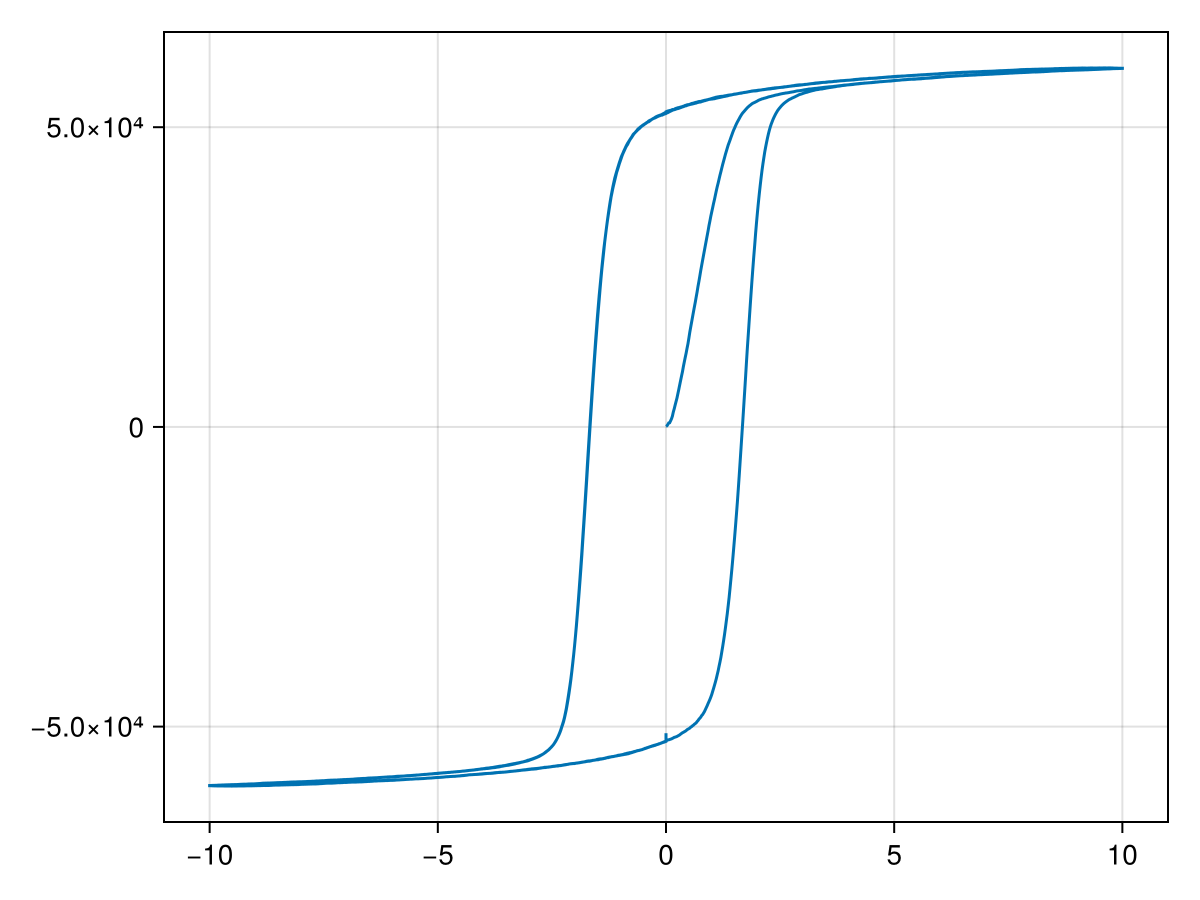

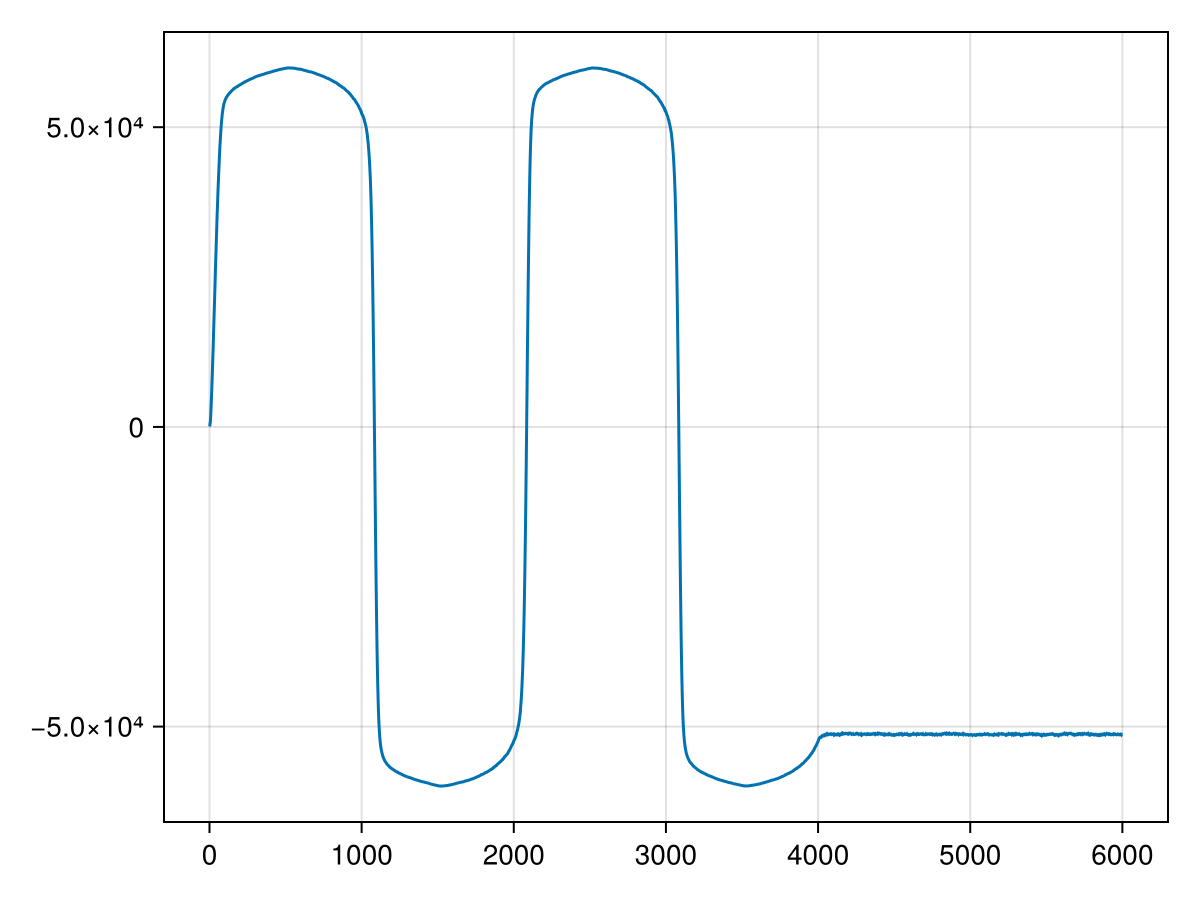

In [73]:
## Run simulation process
fullsweep = xL*yL*zL
Time_fctr = 0.5
SpeedRate = Int(Time_fctr*fullsweep)
### risepoint and Amptitude are factors from pulse
risepoint=500
Amptitude =10
PulseN = 2
Pulsetime = (PulseN * 4 + 4) * risepoint * SpeedRate

compalgo = CompositeAlgorithm((Metropolis, TrianglePulseA), (1, SpeedRate))
createProcess(g, compalgo, lifetime =Pulsetime, amp = Amptitude, numpulses = PulseN, rise_point=risepoint)
### estimate time
est_remaining(process(g))
# Wait until it is done
args = process(g) |> fetch # If you want to close ctr+c
# args = process(g) |> getargs
# EnergyG= args.all_Es;
voltage= args.Metropolis.x
Pr= args.Metropolis.y;

inlineplot() do 
    lines(voltage, Pr)
end


inlineplot() do 
    lines(Pr)
end

# w2=newmakie(lines, voltage, Pr)
# w3=newmakie(lines,Pr)


# show_connections(g,1,1,1)
# visualize_connections(g)